### Import packages

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as TV
import torchaudio.transforms as TA
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import Counter
from sklearn.metrics import accuracy_score


### Set hyperparams and load data

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
learning_rate = 0.01
num_epochs = 5
sample_rate = 16000  # Assuming audio sample rate is 16kHz

data_dir = "data"  # Adjust this path as needed
train_images       = torch.load(f"{data_dir}/training_images.pth")
train_image_labels = torch.load(f"{data_dir}/training_images_labels.pth")
train_audio        = torch.load(f"{data_dir}/training_audio.pth")
train_audio_labels = torch.load(f"{data_dir}/training_audio_labels.pth")
test_images        = torch.load(f"{data_dir}/test_images.pth")
test_image_labels  = torch.load(f"{data_dir}/test_images_labels.pth")
test_audio         = torch.load(f"{data_dir}/test_audio.pth")
test_audio_labels  = torch.load(f"{data_dir}/test_audio_labels.pth")

# --- Check Label Alignment ---
def check_alignment(img_labels, aud_labels, split="train"):
    img = img_labels.cpu().numpy()
    aud = aud_labels.cpu().numpy()
    if len(img) != len(aud):
        print(f"❌ {split} length mismatch: image={len(img)}, audio={len(aud)}")
        return False
    match_ratio = np.mean(img == aud)
    print(f"✅ {split.capitalize()} modality label match: {match_ratio * 100:.2f}%")
    if match_ratio < 0.95:
        print("⚠️ Warning: Possible misalignment.")
    return True

check_alignment(train_image_labels, train_audio_labels, "train")
check_alignment(test_image_labels, test_audio_labels, "test")

# Convert audio waveforms to mel spectrograms
mel_transform = TA.MelSpectrogram(sample_rate=sample_rate, n_mels=64)
train_audio_mel = torch.stack([mel_transform(wf.float()) for wf in train_audio])  # [n_mels, time]
test_audio_mel = torch.stack([mel_transform(wf.float()) for wf in test_audio])

# Ensure shape is consistent: (B, 1, H, W)
if train_images.ndim == 3:
    train_images = train_images.unsqueeze(1).float() / 255.0
    test_images = test_images.unsqueeze(1).float() / 255.0
else:
    train_images = train_images.float() / 255.0
    test_images = test_images.float() / 255.0

# --- Datasets ---
class MultimodalDataset(Dataset):
    def __init__(self, images, audios, labels):
        assert len(images) == len(audios) == len(labels)
        self.images = images
        self.audios = audios
        self.labels = labels

    def __getitem__(self, idx):
        return self.images[idx], self.audios[idx], self.labels[idx]

    def __len__(self):
        return len(self.labels)

# Individual modality datasets
image_train_loader = DataLoader(TensorDataset(train_images, train_image_labels), batch_size=batch_size, shuffle=True)
image_test_loader  = DataLoader(TensorDataset(test_images, test_image_labels), batch_size=batch_size)
audio_train_loader = DataLoader(TensorDataset(train_audio_mel, train_audio_labels), batch_size=batch_size, shuffle=True)
audio_test_loader  = DataLoader(TensorDataset(test_audio_mel, test_audio_labels), batch_size=batch_size)

# Joint dataset for fusion
fusion_train_loader = DataLoader(MultimodalDataset(train_images, train_audio_mel, train_image_labels), batch_size=batch_size, shuffle=True)
fusion_test_loader  = DataLoader(MultimodalDataset(test_images, test_audio_mel, test_image_labels), batch_size=batch_size)


# Dataloaders
#image_train_loader = DataLoader(TensorDataset(train_images, train_image_labels), batch_size=batch_size, shuffle=True)
#image_test_loader  = DataLoader(TensorDataset(test_images, test_image_labels), batch_size=batch_size)
#audio_train_loader = DataLoader(TensorDataset(train_audio_mel, train_audio_labels), batch_size=batch_size, shuffle=True)
#audio_test_loader  = DataLoader(TensorDataset(test_audio_mel, test_audio_labels), batch_size=batch_size)

print("train_audio_mel.shape:", train_audio_mel.shape)
print("Example shape:", train_audio_mel[0].shape)

def analyze_data():
    print("🧠 Data Analysis:")
    # Total samples
    print(f"Total image samples: {len(train_images)}")
    print(f"Total audio samples: {len(train_audio)}")
    # Label distributions
    image_label_counts = Counter(train_image_labels.tolist())
    audio_label_counts = Counter(train_audio_labels.tolist())
    print("\nImage label distribution:")
    for label, count in sorted(image_label_counts.items()):
        print(f"Label {label}: {count} samples")
    print("\nAudio label distribution:")
    for label, count in sorted(audio_label_counts.items()):
        print(f"Label {label}: {count} samples")

analyze_data()

train_audio_mel.shape: torch.Size([17560, 1, 64, 41])
Example shape: torch.Size([1, 64, 41])
🧠 Data Analysis:
Total image samples: 17560
Total audio samples: 17560

Image label distribution:
Label 0: 1783 samples
Label 1: 1800 samples
Label 2: 1740 samples
Label 3: 1800 samples
Label 4: 1747 samples
Label 5: 1587 samples
Label 6: 1771 samples
Label 7: 1800 samples
Label 8: 1732 samples
Label 9: 1800 samples

Audio label distribution:
Label 0: 1783 samples
Label 1: 1800 samples
Label 2: 1740 samples
Label 3: 1800 samples
Label 4: 1747 samples
Label 5: 1587 samples
Label 6: 1771 samples
Label 7: 1800 samples
Label 8: 1732 samples
Label 9: 1800 samples


### Plotting data functions

In [3]:
def plot_image_audio_triplet(image, waveform, label, sample_rate=16000):
    # Convert image
    if image.ndim == 3 and image.shape[0] in [1, 3]:  # [C, H, W]
        image_pil = TV.functional.to_pil_image(image)
    elif image.ndim == 2:
        image_pil = TV.functional.to_pil_image(image.unsqueeze(0))
    else:
        print(f"Unknown image shape: {image.shape}")
        return

    # Convert waveform to numpy
    waveform_np = waveform.numpy()[0]  # Assuming mono channel

    # Compute Mel Spectrogram
    mel_transform = TA.MelSpectrogram(sample_rate=sample_rate, n_mels=64)
    mel_spec_db = mel_transform(waveform.float()).log2()[0, :, :].numpy()

    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    axs[0].imshow(image_pil, cmap='gray')
    axs[0].set_title(f"Image - Label: {label}")
    axs[0].axis("off")

    # Waveform
    time_axis = np.linspace(0, len(waveform_np) / sample_rate, num=len(waveform_np))
    axs[1].plot(time_axis, waveform_np)
    axs[1].set_title("Waveform")
    axs[1].set_xlabel("Time (s)")
    axs[1].set_ylabel("Amplitude")

    # Mel Spectrogram
    im = axs[2].imshow(mel_spec_db, cmap='viridis', aspect='auto', origin='lower')
    axs[2].set_title("Mel Spectrogram")
    axs[2].set_xlabel("Time")
    axs[2].set_ylabel("Mel Filter Bank")
    fig.colorbar(im, ax=axs[2], format='%+2.0f dB')

    plt.tight_layout()
    plt.show()
    
def plot_label_distributions(image_labels, audio_labels):
    fig, axs = plt.subplots(1, 2, figsize=(7, 3))
    # Image labels
    img_counter = Counter(image_labels)
    axs[0].bar(img_counter.keys(), img_counter.values(), color='skyblue')
    axs[0].set_title("Training Image Label Distribution")
    axs[0].set_xlabel("Class")
    axs[0].set_ylabel("Count")
    axs[0].tick_params(axis='x', rotation=45)
    # Audio labels
    audio_counter = Counter(audio_labels)
    axs[1].bar(audio_counter.keys(), audio_counter.values(), color='salmon')
    axs[1].set_title("Training Audio Label Distribution")
    axs[1].set_xlabel("Class")
    axs[1].set_ylabel("Count")
    axs[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

#### Visualizing a sample data (visual + image)

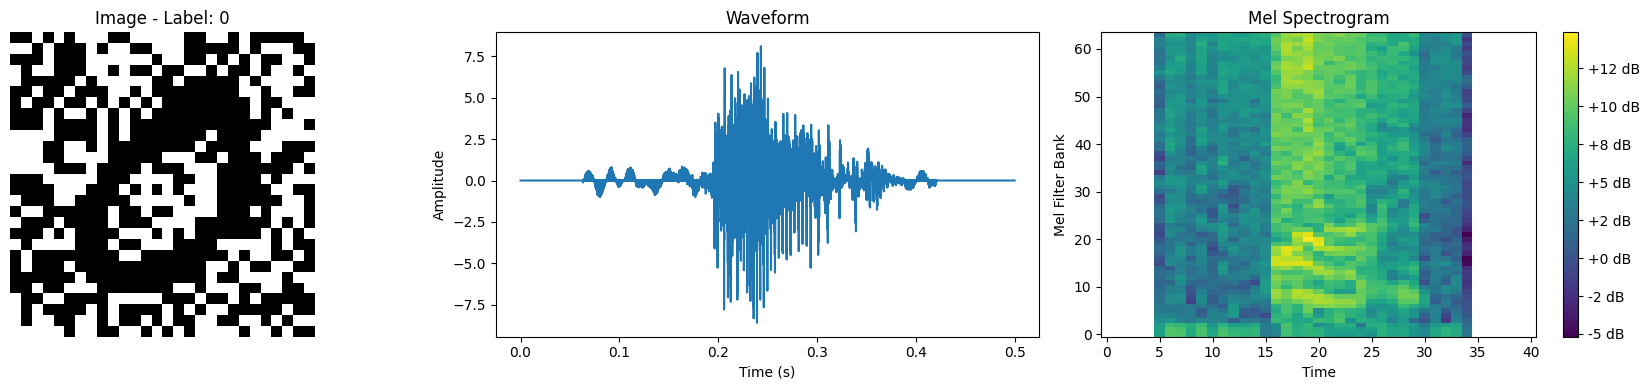

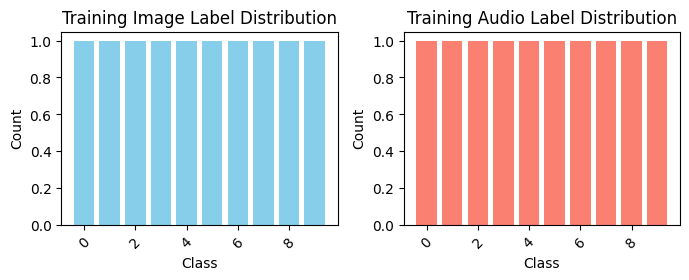

In [4]:
plot_image_audio_triplet(train_images[0], train_audio[0], train_audio_labels[0])
plot_label_distributions(train_image_labels, train_audio_labels)

#### Defined models

In [11]:
class ImageNet(nn.Module): # Image Encoder (CNN)
    def __init__(self, num_classes):
        super(ImageNet, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.fc(self.cnn(x))

class AudioNet(nn.Module):
    def __init__(self, n_mels=64, time_steps=41, num_classes=10):
        super(AudioNet, self).__init__()

        # Convolution + pooling layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Automatically determine flattened feature size
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, n_mels, time_steps)
            x = self.pool(F.relu(self.conv1(dummy_input)))
            x = self.pool(F.relu(self.conv2(x)))
            self.flatten_dim = x.view(1, -1).shape[1]  # Dynamically computed

        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [12]:
def train_and_evaluate(model, train_loader, test_loader, modality_name):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for x, y in tqdm(train_loader, desc=f"{modality_name} Training Epoch {epoch+1}"):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")

    # Evaluation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, preds = torch.max(outputs, 1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    accuracy = 100 * correct / total
    print(f"{modality_name} Test Accuracy: {accuracy:.2f}%")
    return accuracy


In [14]:
num_classes = len(set(train_image_labels.tolist()))

image_model = ImageNet(num_classes)
audio_model = AudioNet(n_mels=64, time_steps=41, num_classes=10).to(device)

acc_image = train_and_evaluate(image_model, image_train_loader, image_test_loader, "Image")
acc_audio = train_and_evaluate(audio_model, audio_train_loader, audio_test_loader, "Audio")

from tabulate import tabulate

results = [
    ["Image Modality", f"{acc_image:.2f}%"],
    ["Audio Modality", f"{acc_audio:.2f}%"]
]

print("\n🔍 Modality Comparison:")
print(tabulate(results, headers=["Modality", "Test Accuracy"], tablefmt="github"))


Image Training Epoch 1: 100%|██████████| 275/275 [00:06<00:00, 45.28it/s]


Epoch 1 Loss: 2.3129


Image Training Epoch 2: 100%|██████████| 275/275 [00:06<00:00, 44.66it/s]


Epoch 2 Loss: 2.3031


Image Training Epoch 3: 100%|██████████| 275/275 [00:06<00:00, 45.25it/s]


Epoch 3 Loss: 2.3031


Image Training Epoch 4: 100%|██████████| 275/275 [00:06<00:00, 45.01it/s]


Epoch 4 Loss: 2.3029


Image Training Epoch 5: 100%|██████████| 275/275 [00:06<00:00, 45.41it/s]


Epoch 5 Loss: 2.3030
Image Test Accuracy: 10.02%


Audio Training Epoch 1: 100%|██████████| 275/275 [00:16<00:00, 16.80it/s]


Epoch 1 Loss: 784.6471


Audio Training Epoch 2: 100%|██████████| 275/275 [00:16<00:00, 16.78it/s]


Epoch 2 Loss: 2.3598


Audio Training Epoch 3: 100%|██████████| 275/275 [00:16<00:00, 16.57it/s]


Epoch 3 Loss: 2.3500


Audio Training Epoch 4: 100%|██████████| 275/275 [00:16<00:00, 16.74it/s]


Epoch 4 Loss: 2.3449


Audio Training Epoch 5: 100%|██████████| 275/275 [00:16<00:00, 16.64it/s]


Epoch 5 Loss: 2.3197
Audio Test Accuracy: 9.59%

🔍 Modality Comparison:
| Modality       | Test Accuracy   |
|----------------|-----------------|
| Image Modality | 10.02%          |
| Audio Modality | 9.59%           |


In [17]:
# --- Models ---
class ResNet18Gray(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        from torchvision.models import resnet18
        self.model = resnet18(weights=None)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

class AudioCNNImproved(nn.Module):
    def __init__(self, n_mels=64, time_steps=41, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2)
        )
        with torch.no_grad():
            dummy = torch.zeros(1, 1, n_mels, time_steps)
            out = self.net(dummy)
            self.flat_dim = out.view(1, -1).shape[1]
        self.classifier = nn.Sequential(
            nn.Linear(self.flat_dim, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.net(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# --- Training & Evaluation ---
def train_and_evaluate(model, train_loader, test_loader, modality):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())
    acc = accuracy_score(torch.cat(all_labels), torch.cat(all_preds))
    print(f"{modality} Accuracy: {acc * 100:.2f}%")
    return acc * 100

# --- Run Training ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_model = ResNet18Gray(num_classes)
audio_model = AudioCNNImproved(n_mels=64, time_steps=41, num_classes=num_classes)

acc_image = train_and_evaluate(image_model, image_train_loader, image_test_loader, "Image")
acc_audio = train_and_evaluate(audio_model, audio_train_loader, audio_test_loader, "Audio")

# --- Print Results ---
from tabulate import tabulate
results = [["Image", f"{acc_image:.2f}%"], ["Audio", f"{acc_audio:.2f}%"]]
print(tabulate(results, headers=["Modality", "Accuracy"]))


Image Accuracy: 85.71%
Audio Accuracy: 15.04%
Modality    Accuracy
----------  ----------
Image       85.71%
Audio       15.04%


#### Fusion

In [18]:
class SimpleConcatMultimodal(nn.Module):
    def __init__(self, img_model, audio_model, num_classes=10):
        super().__init__()
        self.img_feat = nn.Sequential(*list(img_model.model.children())[:-1])  # remove fc
        self.audio_feat = nn.Sequential(*list(audio_model.net.children()))
        self.audio_flat_dim = audio_model.flat_dim

        self.classifier = nn.Sequential(
            nn.Linear(img_model.model.fc.in_features + self.audio_flat_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, img, audio):
        img_feat = self.img_feat(img)
        img_feat = img_feat.view(img_feat.size(0), -1)
        audio_feat = self.audio_feat(audio)
        audio_feat = audio_feat.view(audio_feat.size(0), -1)
        combined = torch.cat([img_feat, audio_feat], dim=1)
        return self.classifier(combined)


class CrossModalAttention(nn.Module):
    def __init__(self, img_model, audio_model, num_classes=10, embed_dim=256):
        super().__init__()
        self.img_feat = nn.Sequential(*list(img_model.model.children())[:-1])
        self.audio_feat = nn.Sequential(*list(audio_model.net.children()))
        self.audio_flat_dim = audio_model.flat_dim
        self.img_embed = nn.Linear(img_model.model.fc.in_features, embed_dim)
        self.audio_embed = nn.Linear(self.audio_flat_dim, embed_dim)

        self.attention = nn.MultiheadAttention(embed_dim, num_heads=4, batch_first=True)

        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, img, audio):
        img_feat = self.img_feat(img).view(img.size(0), -1)  # (B, feat_dim)
        audio_feat = self.audio_feat(audio).view(audio.size(0), -1)  # (B, feat_dim)
        img_emb = self.img_embed(img_feat).unsqueeze(1)  # (B, 1, embed_dim)
        audio_emb = self.audio_embed(audio_feat).unsqueeze(1)  # (B, 1, embed_dim)

        # Concatenate sequence length = 2
        x = torch.cat([img_emb, audio_emb], dim=1)  # (B, 2, embed_dim)
        attn_out, _ = self.attention(x, x, x)  # Self-attention on combined embeddings
        fused = attn_out.mean(dim=1)  # (B, embed_dim)

        return self.classifier(fused)
    
def train_fusion_model(model, train_loader, test_loader):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        model.train()
        for img, aud, label in tqdm(train_loader, desc=f"Fusion Epoch {epoch+1}"):
            img, aud, label = img.to(device), aud.to(device), label.to(device)
            optimizer.zero_grad()
            outputs = model(img, aud)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for img, aud, label in test_loader:
            img, aud, label = img.to(device), aud.to(device), label.to(device)
            outputs = model(img, aud)
            pred = outputs.argmax(dim=1)
            correct += (pred == label).sum().item()
            total += label.size(0)
    return 100 * correct / total


In [ ]:
# --- Run Fusion Models ---
fusion_train_loader = DataLoader(TensorDataset(train_images, train_audio_mel, train_image_labels), batch_size=batch_size, shuffle=True)
fusion_test_loader = DataLoader(TensorDataset(test_images, test_audio_mel, test_image_labels), batch_size=batch_size)

fusion_model_concat = SimpleConcatMultimodal(image_model, audio_model)
fusion_model_attn = CrossModalAttention(image_model, audio_model)

acc_fusion_concat = train_fusion_model(fusion_model_concat, fusion_train_loader, fusion_test_loader)
acc_fusion_attn = train_fusion_model(fusion_model_attn, fusion_train_loader, fusion_test_loader)

# --- Results ---
results = [
    ["Image Only", f"{acc_image:.2f}%"],
    ["Audio Only", f"{acc_audio:.2f}%"],
    ["Fusion (Concat)", f"{acc_fusion_concat:.2f}%"],
    ["Fusion (Attention)", f"{acc_fusion_attn:.2f}%"]
]
print(tabulate(results, headers=["Model", "Accuracy"]))

Fusion Epoch 5: 100%|██████████| 275/275 [02:02<00:00,  2.24it/s]


Model               Accuracy
------------------  ----------
Image Only          85.71%
Audio Only          15.04%
Fusion (Concat)     76.72%
Fusion (Attention)  10.24%
